In [1]:
%cd ..

/tf/fiit_nn_project


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

from src.data.load_data import load_dataset
from src.data.processing import resize_images, \
    calculate_bboxes_middle_points, encode_anns_to_yolo, \
    decode_yolo_to_anns, input_fn
from src.utils import plot_img_with_bboxes, is_point_in_bbox
from src.models.models import base_model
from src.models.models import darknet19_model
from src.models.models import darknet19_model_resnet
from src.models.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preprocessing

In [11]:
dev_x, dev_y = load_dataset('data/datasets/dev-100.npz')
print(len(dev_x), len(dev_y))

100 100


In [12]:
dev_x_new = resize_images(dev_x, (260, 260))

In [13]:
dev_y_new = calculate_bboxes_middle_points(dev_y)

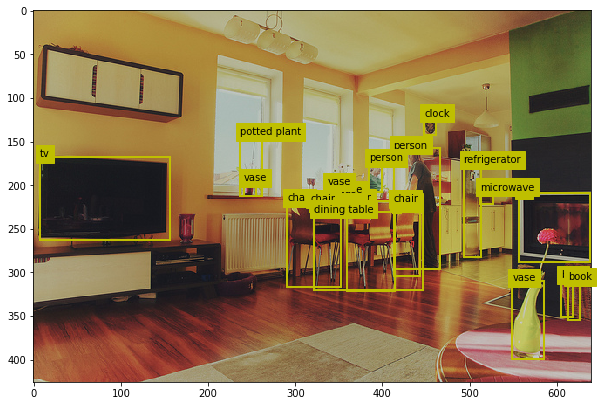

In [14]:
plot_img_with_bboxes(dev_x[0], dev_y[0])

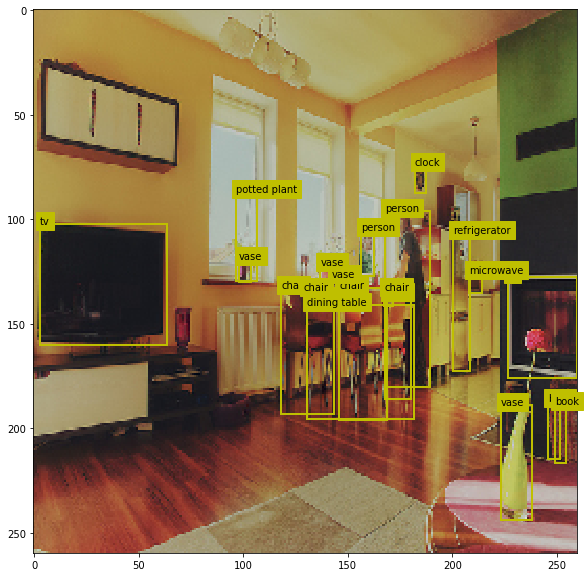

In [15]:
plot_img_with_bboxes(dev_x_new[0], dev_y[0])

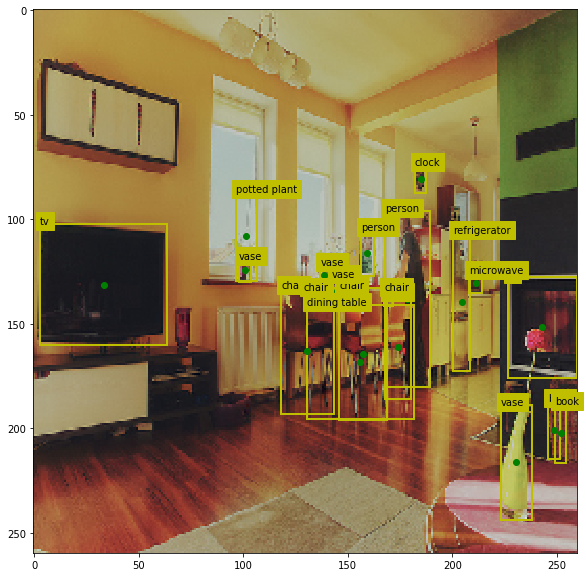

In [16]:
plot_img_with_bboxes(dev_x_new[0], dev_y_new[0])

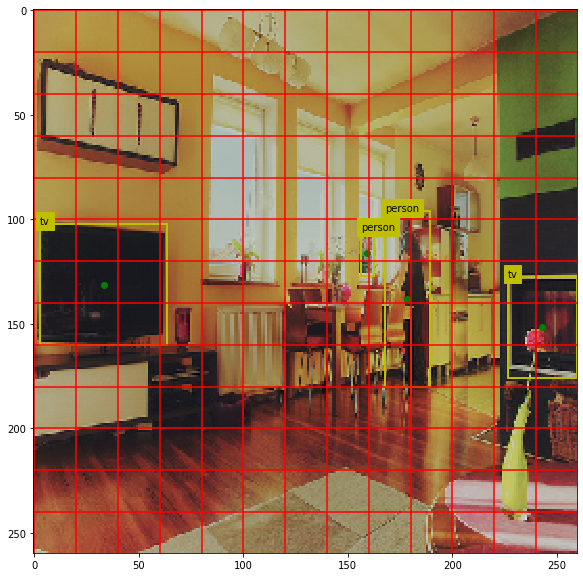

In [17]:
img_size = (260, 260)
grid_size = (13, 13)
yolo_anns = encode_anns_to_yolo(dev_y_new[0], img_size, grid_size, np.array(['dog', 'cat', 'person', 'tv']))
anns = decode_yolo_to_anns(yolo_anns, img_size, grid_size, np.array(['dog', 'cat', 'person', 'tv']))
plot_img_with_bboxes(dev_x_new[0], anns, grid=grid_size)

# Data pipeline and basic model

In [4]:
dev_x, dev_y = load_dataset('data/datasets/valid1000-256.npz')
print(len(dev_x), len(dev_y))

1000 1000


In [5]:
dev_x_new = resize_images(dev_x, (256, 256))

In [6]:
dev_y_new = calculate_bboxes_middle_points(dev_y)

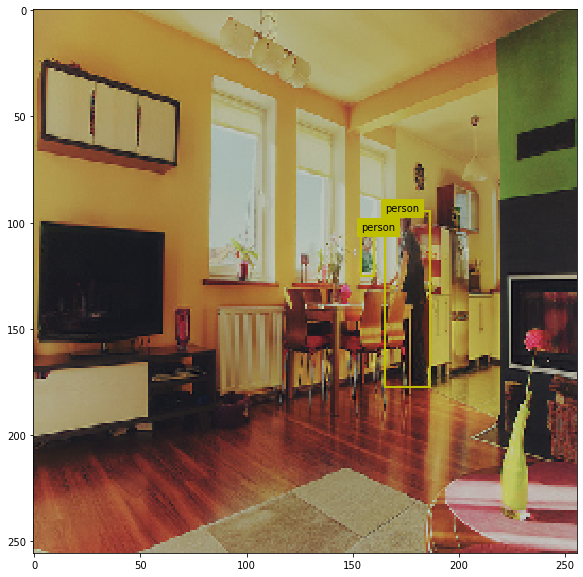

In [7]:
plot_img_with_bboxes(dev_x[0], dev_y[0])

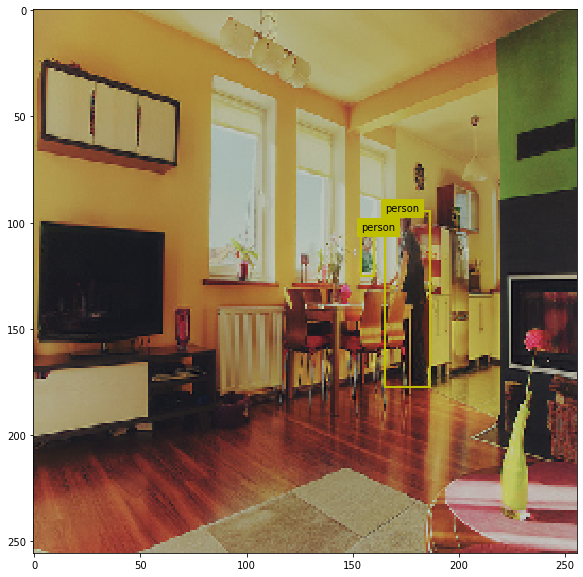

In [8]:
plot_img_with_bboxes(dev_x_new[0], dev_y[0])

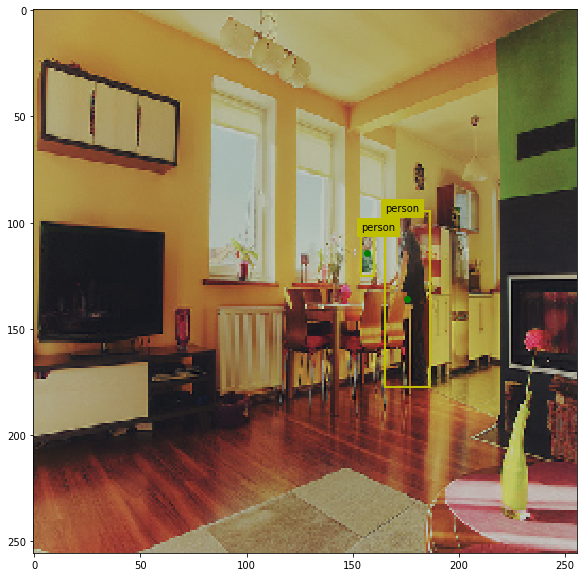

In [9]:
plot_img_with_bboxes(dev_x_new[0], dev_y_new[0])

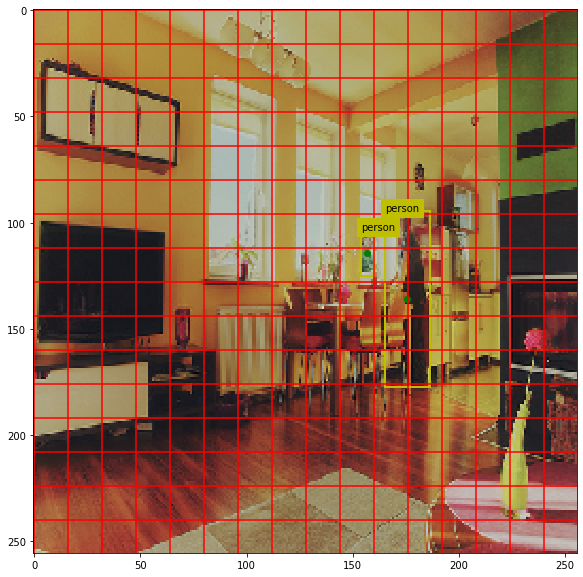

In [10]:
img_size = (256, 256)
grid_size = (16, 16)
categories = np.array(['person'])
yolo_anns = encode_anns_to_yolo(dev_y_new[0], img_size, grid_size, categories)
anns = decode_yolo_to_anns(yolo_anns, img_size, grid_size, categories)
plot_img_with_bboxes(dev_x_new[0], anns, grid=grid_size)

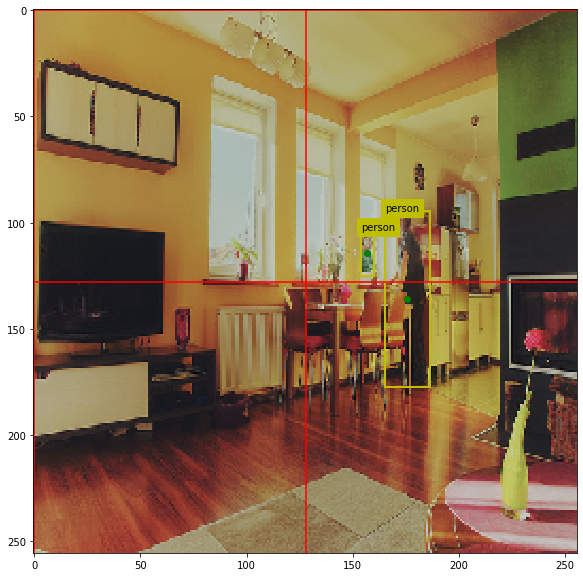

In [11]:
img_size = (256, 256)
grid_size = (2, 2)
categories = np.array(['person'])
yolo_anns = encode_anns_to_yolo(dev_y_new[0], img_size, grid_size, categories)
anns = decode_yolo_to_anns(yolo_anns, img_size, grid_size, categories)
plot_img_with_bboxes(dev_x_new[0], anns, grid=grid_size)

In [12]:
encode_anns_to_yolo(dev_y_new[0], img_size, grid_size, categories)

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [1.        , 0.22496875, 0.89239436, 0.023625  , 0.08389671,
         1.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [1.        , 0.37289062, 0.06392018, 0.08289062, 0.32396713,
         1.        ]]], dtype=float32)

In [13]:
dev_y_new[0]

[[[0.645, 0.3699765258215963, 0.082890625, 0.3239671361502347],
  'person',
  (0.6864453125000001, 0.5319600938967136)],
 [[0.600671875, 0.40424882629107983, 0.023625, 0.08389671361502347],
  'person',
  (0.612484375, 0.4461971830985916)]]

In [14]:
img_size = (256, 256)
grid_size = (4, 4)
epochs = 100
# categories = np.array(['person'])

yolo_anns = np.array([
    encode_anns_to_yolo(y, img_size, grid_size)
    # encode_anns_to_yolo(y, img_size, grid_size, categories)
    for y in dev_y_new
])
yolo_anns.shape

(1000, 4, 4, 5)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 4, 4, 5)), types: (tf.float32, tf.float32)>


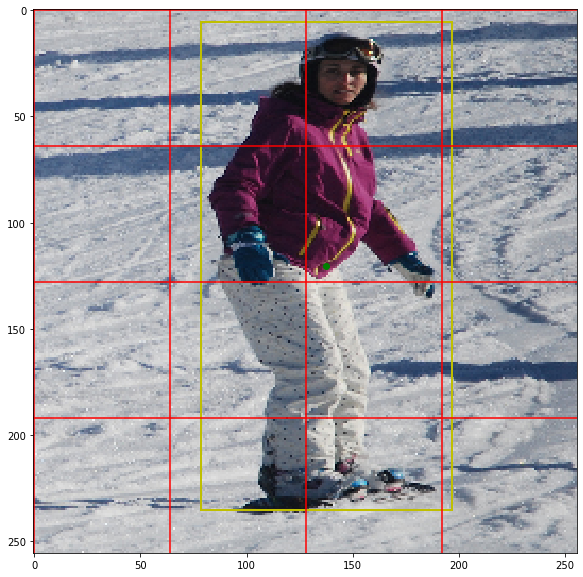

In [15]:
num_of_images = 1000
batch_size = 32
dev_dataset = input_fn(dev_x_new[:num_of_images], yolo_anns[:num_of_images], is_training=True, batch_size=batch_size)
print(dev_dataset)

for x, y in dev_dataset:
    anns = decode_yolo_to_anns(y[0].numpy(), img_size, grid_size)
    # print(x[0])
    # print(y)
    # print(anns)
    plot_img_with_bboxes(x[0], anns, grid=grid_size)
    break

In [16]:
model = darknet19_model_resnet(grid_size, (256, 256, 3), bn_momentum=0.99, learning_rate=0.00001, l_coord=5.0, l_noobj=0.08)
model.summary()

Model: "darknet19_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 256, 256, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________

In [ ]:
#callback = LearningRateScheduler(scheduler)
model.fit(
    dev_dataset,
    epochs=epochs,
    steps_per_epoch=num_of_images/batch_size,
#    callbacks=[callback]
)

In [17]:
model.load_weights('checkpoint2/model.ckpt')

# Validation pictures

In [56]:
dev_x, dev_y = load_dataset('data/datasets/valid1000-256.npz')
print(len(dev_x), len(dev_y))

1000 1000


In [57]:
dev_x_new = resize_images(dev_x, (256, 256))

In [58]:
dev_y_new = calculate_bboxes_middle_points(dev_y)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 4, 4, 5)), types: (tf.float32, tf.float32)>


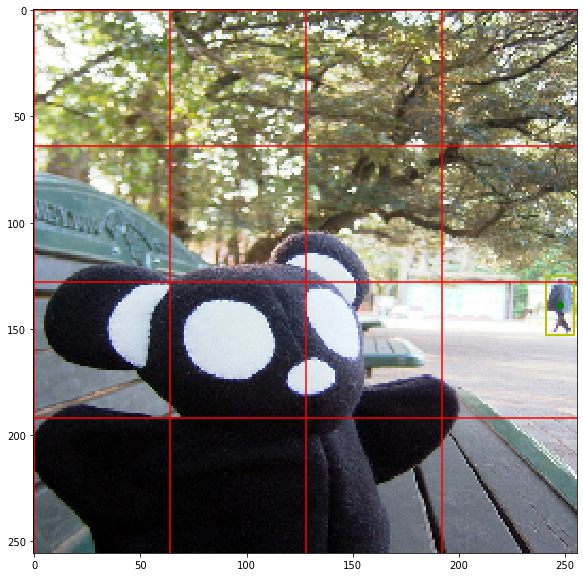

In [59]:
num_of_images = 100
new_dev_dataset = input_fn(dev_x_new[:num_of_images], yolo_anns[:num_of_images], is_training=False, batch_size=batch_size)
print(dev_dataset)

for x, y in dev_dataset:
    anns = decode_yolo_to_anns(y[0].numpy(), img_size, grid_size)
    # print(x[0])
    # print(y)
    # print(anns)
    plot_img_with_bboxes(x[0], anns, grid=grid_size)
    break

In [60]:
p = model.predict(new_dev_dataset, steps=num_of_images/batch_size)

[[[0.05446807 0.6484686  0.5466381  0.03869268 0.08855245]
  [0.0762811  0.5352129  0.6106921  0.03127301 0.06580529]
  [0.09643972 0.40518063 0.656695   0.08063221 0.18658072]
  [0.05742291 0.53659695 0.48113135 0.03852293 0.07278115]]

 [[0.10422876 0.62811863 0.556234   0.04267913 0.10705081]
  [0.16484118 0.7286777  0.53395045 0.12295723 0.13515052]
  [0.79151964 0.4152642  0.80720615 0.31272796 0.6109702 ]
  [0.17015967 0.54938364 0.47431782 0.03474909 0.09383532]]

 [[0.09988591 0.48950255 0.40921485 0.06295046 0.18160713]
  [0.2770025  0.7390399  0.25644696 0.12532964 0.38993144]
  [0.8930016  0.6340533  0.14918822 0.32525116 0.8040477 ]
  [0.13731152 0.21612492 0.6308281  0.14804664 0.4607084 ]]

 [[0.08697265 0.2447573  0.41571915 0.02082521 0.05902392]
  [0.14528394 0.36080417 0.5083612  0.07410741 0.08486378]
  [0.16788232 0.45739943 0.22347456 0.11541095 0.10849768]
  [0.09783095 0.42403957 0.30085236 0.05469674 0.09312776]]]


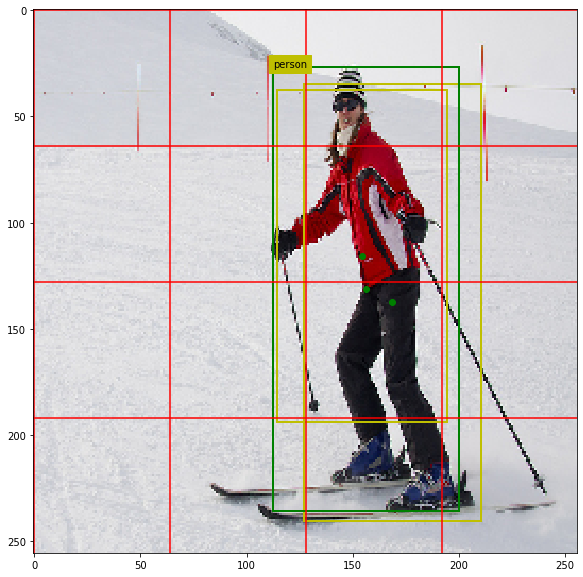

In [61]:
img_id = 1
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.10270685 0.67135584 0.63412577 0.06995413 0.1318855 ]
  [0.12220582 0.48661935 0.6049027  0.09291887 0.13530037]
  [0.08382851 0.5337892  0.6521068  0.08515218 0.10094374]
  [0.1119141  0.37450412 0.6190381  0.11163035 0.12656763]]

 [[0.15742058 0.5329469  0.6432006  0.07697731 0.187675  ]
  [0.35139835 0.41118678 0.6046917  0.1098856  0.2663166 ]
  [0.41783798 0.46883482 0.65732133 0.22972348 0.32152742]
  [0.19271278 0.5765135  0.52397555 0.07981056 0.19493204]]

 [[0.08033457 0.6147672  0.16405728 0.0677048  0.08530164]
  [0.7054534  0.6550702  0.2796446  0.30464166 0.5393001 ]
  [0.5294757  0.23913229 0.27656126 0.24997568 0.45105168]
  [0.07290277 0.60683495 0.3180148  0.05132112 0.170483  ]]

 [[0.07148221 0.29199937 0.3982314  0.05437046 0.11529514]
  [0.1030966  0.4140187  0.30861092 0.14093524 0.19539452]
  [0.08703533 0.31412256 0.23217264 0.12531513 0.1643529 ]
  [0.0761534  0.6223585  0.23767507 0.03958192 0.12797052]]]


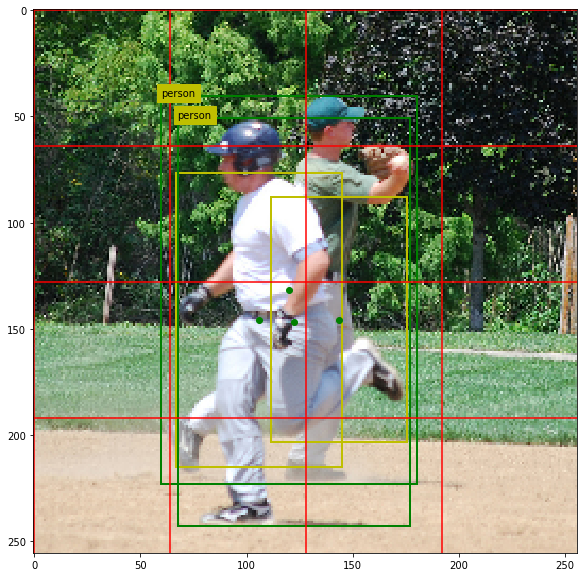

In [62]:
img_id = 2
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.06749502 0.5614924  0.5327418  0.05984524 0.08315137]
  [0.12345254 0.4150116  0.5551935  0.09112328 0.11445388]
  [0.09446698 0.44262776 0.5352274  0.05252275 0.06532106]
  [0.08592591 0.5830067  0.5227164  0.06221759 0.13661143]]

 [[0.12952131 0.5383736  0.5297018  0.05977938 0.10219342]
  [0.19664192 0.59283996 0.6177271  0.18124297 0.26872516]
  [0.42255604 0.403652   0.8967335  0.25628653 0.357656  ]
  [0.16311449 0.48204237 0.47449732 0.08863056 0.16113415]]

 [[0.14429617 0.5050953  0.57091576 0.09014872 0.24477345]
  [0.3673668  0.5486897  0.48313087 0.24492598 0.31613263]
  [0.80629027 0.4198535  0.4549176  0.42110458 0.6938919 ]
  [0.13707256 0.56528306 0.5435812  0.09699687 0.22440004]]

 [[0.1589163  0.44154873 0.3311432  0.07900047 0.1428523 ]
  [0.21775016 0.6154332  0.23193347 0.18050325 0.20852408]
  [0.27618104 0.40939456 0.20058852 0.21021149 0.30671325]
  [0.16923875 0.36544216 0.27052605 0.08811238 0.12067315]]]


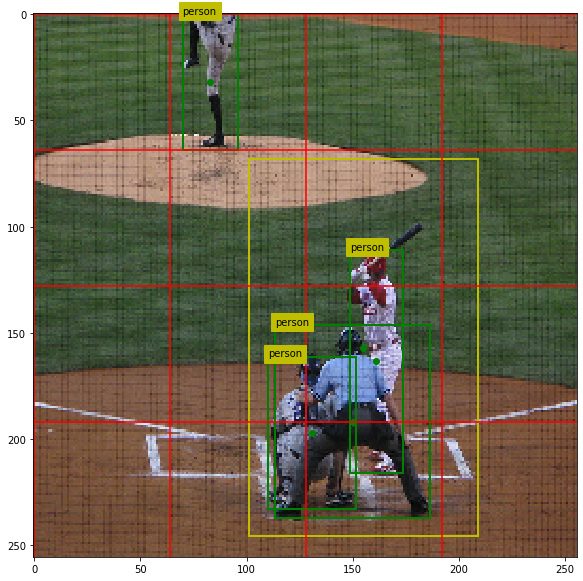

In [72]:
img_id = 12
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.10476333 0.56021076 0.6374876  0.06137082 0.10155308]
  [0.08620894 0.46739846 0.61340004 0.03189021 0.08028957]
  [0.07707927 0.5334038  0.545168   0.06510213 0.09102616]
  [0.09037006 0.49416998 0.53423506 0.05265492 0.10502005]]

 [[0.1506285  0.75032055 0.56889695 0.05948707 0.13504505]
  [0.3075598  0.58111584 0.6707912  0.09373003 0.1813027 ]
  [0.35536265 0.29209644 0.72200096 0.1070883  0.19597572]
  [0.1577403  0.32402843 0.49753627 0.08379379 0.17041966]]

 [[0.13745242 0.6924318  0.34338236 0.07636842 0.1966196 ]
  [0.5500045  0.80610067 0.20477292 0.27578634 0.44638175]
  [0.54280335 0.14404005 0.2843488  0.17978299 0.31226516]
  [0.15201145 0.43396366 0.3381834  0.07142323 0.2599013 ]]

 [[0.10040447 0.28115803 0.45404863 0.04349637 0.132916  ]
  [0.10703793 0.38242254 0.3222929  0.18036038 0.14879686]
  [0.11817983 0.42922148 0.3355115  0.15131608 0.17684954]
  [0.117906   0.5882374  0.24954239 0.07216662 0.18855426]]]


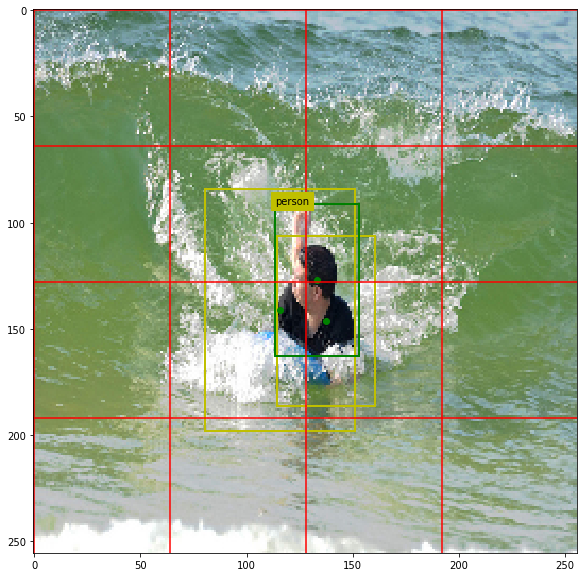

In [73]:
img_id = 13
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.21057954 0.5514509  0.7206217  0.09467205 0.2329168 ]
  [0.1908235  0.49905995 0.69431067 0.0978466  0.19963178]
  [0.241983   0.51923114 0.7157543  0.1452735  0.224666  ]
  [0.1702731  0.40429977 0.7790562  0.11016634 0.30549127]]

 [[0.33227763 0.6763223  0.5408812  0.12820226 0.40994918]
  [0.40586138 0.66866827 0.5679817  0.14525133 0.52157396]
  [0.309196   0.46658903 0.4902808  0.15651852 0.46232876]
  [0.31810057 0.36624494 0.5352702  0.11449999 0.40179208]]

 [[0.4979878  0.6471323  0.42882007 0.25737768 0.6235148 ]
  [0.4532306  0.5565939  0.3867862  0.24586341 0.5814335 ]
  [0.35302338 0.5835805  0.35507673 0.10285994 0.44288713]
  [0.39337498 0.34902364 0.4091669  0.1458258  0.56369764]]

 [[0.20033532 0.50585806 0.29090983 0.10417962 0.27024376]
  [0.18049845 0.3505235  0.2845104  0.14225379 0.3119064 ]
  [0.153692   0.432472   0.3544586  0.24537036 0.24810752]
  [0.1748159  0.45074847 0.42829585 0.10041651 0.23007083]]]


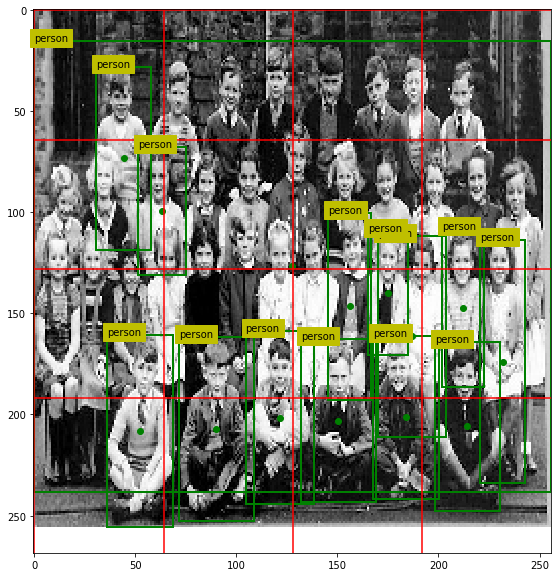

In [74]:
img_id = 14
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.22322354 0.6270914  0.6199598  0.18471697 0.21943504]
  [0.27790016 0.39755967 0.4669504  0.2574265  0.1630888 ]
  [0.2197415  0.6201088  0.5960226  0.25632787 0.22169709]
  [0.25327516 0.37945512 0.47859678 0.1669141  0.18449861]]

 [[0.30032754 0.64027864 0.53749144 0.17360044 0.39897373]
  [0.52121836 0.7901394  0.75258267 0.6440639  0.6085885 ]
  [0.7030363  0.2510623  0.66240555 0.66148174 0.610835  ]
  [0.23362193 0.4245529  0.48368767 0.2574121  0.406451  ]]

 [[0.1877914  0.5690376  0.5578408  0.1570766  0.24016413]
  [0.3178997  0.65383106 0.27741235 0.51640904 0.47971708]
  [0.5669335  0.4765087  0.17871252 0.44415402 0.529786  ]
  [0.2553258  0.55900955 0.5308652  0.16498685 0.40307224]]

 [[0.12979525 0.4366337  0.3860327  0.18912965 0.21613908]
  [0.09728158 0.40317532 0.37673748 0.30155495 0.19311482]
  [0.09656274 0.4135893  0.39744294 0.16558379 0.14070144]
  [0.14778388 0.48483852 0.36628503 0.20101792 0.30266178]]]


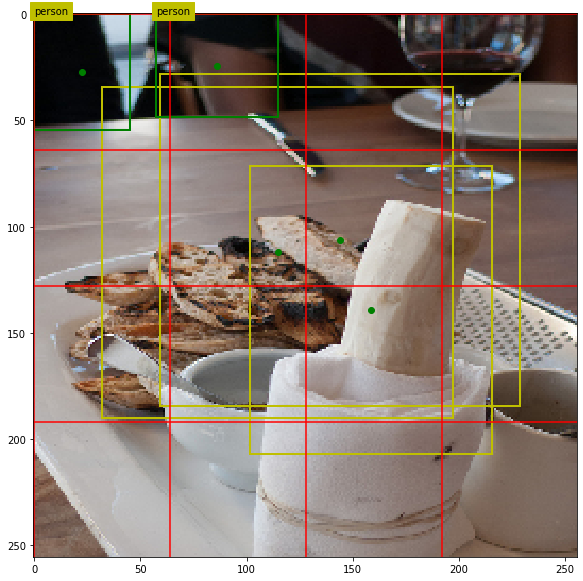

In [75]:
img_id = 15
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.06915563 0.5271801  0.60301137 0.07417634 0.05575672]
  [0.08391586 0.6044469  0.7230113  0.06507799 0.08988094]
  [0.04345876 0.27631974 0.6665581  0.07855228 0.13310608]
  [0.04975179 0.43240577 0.6788366  0.04671982 0.05944887]]

 [[0.10436037 0.4815673  0.71285164 0.0835861  0.20903787]
  [0.32467115 0.74571455 0.60672617 0.12920278 0.21576968]
  [0.2058788  0.10105544 0.62083346 0.15128839 0.25612003]
  [0.12422115 0.449094   0.5120684  0.06178111 0.0684323 ]]

 [[0.27982807 0.56116754 0.5699906  0.08680508 0.2951163 ]
  [0.3572169  0.6911012  0.48068267 0.13010406 0.33700538]
  [0.38818005 0.40528885 0.61712897 0.10900691 0.2693032 ]
  [0.14721587 0.33933964 0.67605925 0.1001485  0.1174174 ]]

 [[0.09145269 0.4975453  0.25455803 0.0263437  0.06007451]
  [0.07080671 0.6367413  0.31202555 0.02784836 0.07528171]
  [0.11275506 0.4000237  0.28796327 0.06095168 0.12472582]
  [0.12650657 0.42874038 0.26100555 0.05104503 0.06927273]]]


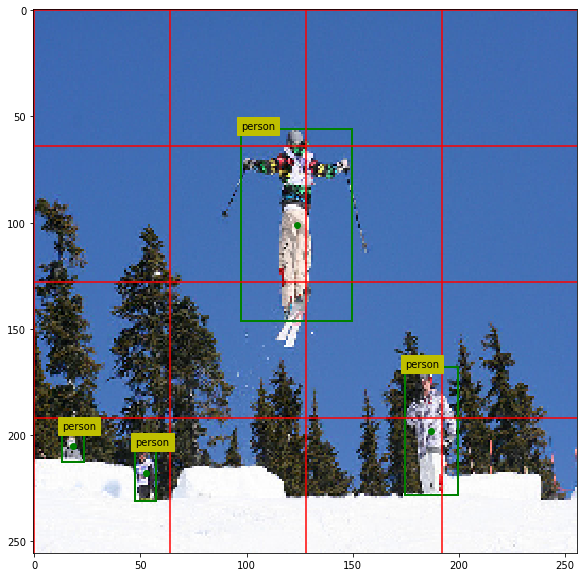

In [76]:
img_id = 16
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.1527454  0.53630364 0.8182232  0.11218435 0.23472121]
  [0.13230234 0.37185955 0.58818346 0.12472385 0.15642372]
  [0.16251114 0.6874743  0.6382184  0.2264899  0.2388339 ]
  [0.17890012 0.4298543  0.61294246 0.0872654  0.21478966]]

 [[0.42504606 0.64742637 0.61104    0.11826065 0.5047157 ]
  [0.5365842  0.5702014  0.7982534  0.27858382 0.5657398 ]
  [0.4292196  0.4678131  0.63212734 0.1789613  0.47781774]
  [0.24706435 0.5060532  0.6420008  0.15920141 0.31245452]]

 [[0.55439866 0.6254229  0.24189425 0.29353505 0.8098928 ]
  [0.46988848 0.49465397 0.23501873 0.33109713 0.48723564]
  [0.37153983 0.45880473 0.31942052 0.17124647 0.35800457]
  [0.33927572 0.53297615 0.46749184 0.10997567 0.3829878 ]]

 [[0.22527465 0.5064668  0.3042878  0.14688915 0.28701285]
  [0.19536361 0.33465695 0.31542844 0.3440659  0.2936123 ]
  [0.11885166 0.5731035  0.4042894  0.2517919  0.25541735]
  [0.16764808 0.5682907  0.47081736 0.14137408 0.27897897]]]


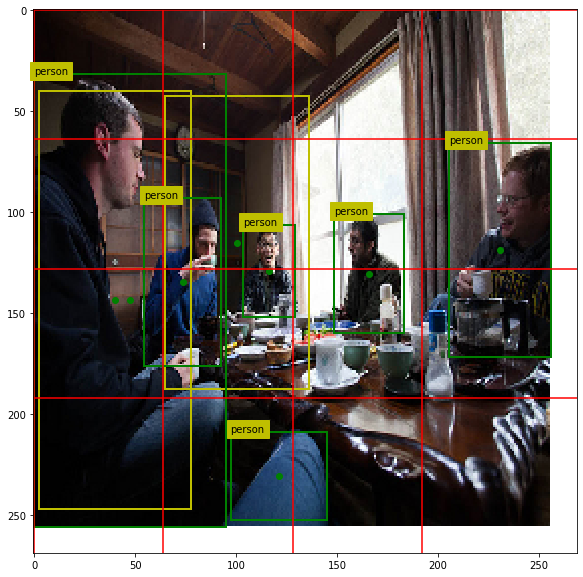

In [78]:
img_id = 54
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.10318288 0.5282422  0.8663372  0.05271274 0.12353638]
  [0.11058864 0.66365176 0.7472857  0.10009509 0.13379183]
  [0.10976443 0.55649614 0.71873224 0.0906201  0.09978518]
  [0.11431113 0.48622927 0.5622867  0.07917312 0.162664  ]]

 [[0.4503916  0.72576404 0.67148376 0.1884298  0.54337317]
  [0.5429352  0.4397171  0.6121027  0.3085062  0.54807615]
  [0.2696089  0.35030678 0.78080523 0.29519996 0.4327252 ]
  [0.23763108 0.328525   0.7508713  0.13564473 0.23768535]]

 [[0.5585618  0.58521307 0.22790992 0.27634376 0.7083787 ]
  [0.5929961  0.3197803  0.31429297 0.4422283  0.59825194]
  [0.46250957 0.6111849  0.54342127 0.3008966  0.41964635]
  [0.412029   0.51822317 0.4504903  0.11586183 0.36282307]]

 [[0.1966905  0.57841736 0.31488815 0.1387071  0.21978566]
  [0.17668897 0.45334485 0.29475528 0.27587715 0.2496197 ]
  [0.1349709  0.5506174  0.29485923 0.3633254  0.30460203]
  [0.18789232 0.37952033 0.43035245 0.19340113 0.2002061 ]]]


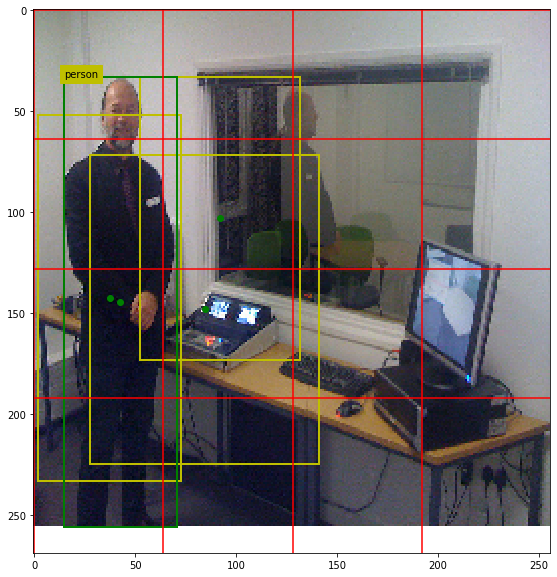

In [79]:
img_id = 53
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

# Train pictures

In [25]:
dev_x, dev_y = load_dataset('data/datasets/train100-256.npz')
print(len(dev_x), len(dev_y))

100 100


In [26]:
dev_x_new = resize_images(dev_x, (256, 256))

In [27]:
dev_y_new = calculate_bboxes_middle_points(dev_y)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 4, 4, 5)), types: (tf.float32, tf.float32)>


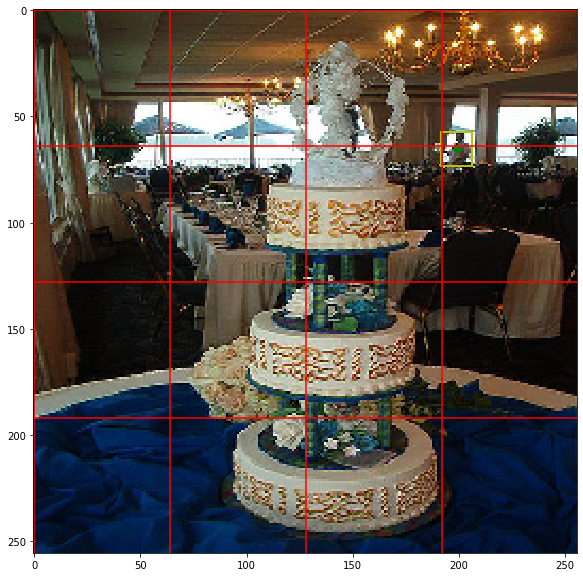

In [28]:
num_of_images = 100
new_dev_dataset = input_fn(dev_x_new[:num_of_images], yolo_anns[:num_of_images], is_training=False, batch_size=batch_size)
print(dev_dataset)

for x, y in dev_dataset:
    anns = decode_yolo_to_anns(y[0].numpy(), img_size, grid_size)
    # print(x[0])
    # print(y)
    # print(anns)
    plot_img_with_bboxes(x[0], anns, grid=grid_size)
    break

In [29]:
p = model.predict(new_dev_dataset, steps=num_of_images/batch_size)

[[[0.07761914 0.5883361  0.67451227 0.04765531 0.10638684]
  [0.16501373 0.48694554 0.5462095  0.09875467 0.10290593]
  [0.09892568 0.5181651  0.62907356 0.08104795 0.12269267]
  [0.09752133 0.32446647 0.64374083 0.08121815 0.15376016]]

 [[0.12703225 0.6147503  0.45844933 0.03554195 0.08276302]
  [0.3057096  0.49075425 0.71531147 0.15212765 0.20033902]
  [0.28924015 0.47539735 0.72245616 0.18131262 0.24277765]
  [0.11816791 0.41553372 0.44392258 0.05403823 0.06833503]]

 [[0.11716089 0.58239913 0.1773625  0.08086067 0.12690058]
  [0.613126   0.61259454 0.2912532  0.30773297 0.65045977]
  [0.55423564 0.2475163  0.3719839  0.14001778 0.39722607]
  [0.10361791 0.47995207 0.2849173  0.08546957 0.25393748]]

 [[0.11196637 0.40463495 0.42513472 0.06635487 0.08981717]
  [0.11991313 0.48536798 0.24027309 0.12980217 0.30737084]
  [0.10329282 0.4324321  0.41865182 0.11709121 0.16724262]
  [0.13622382 0.52382594 0.40304214 0.09205309 0.15496144]]]


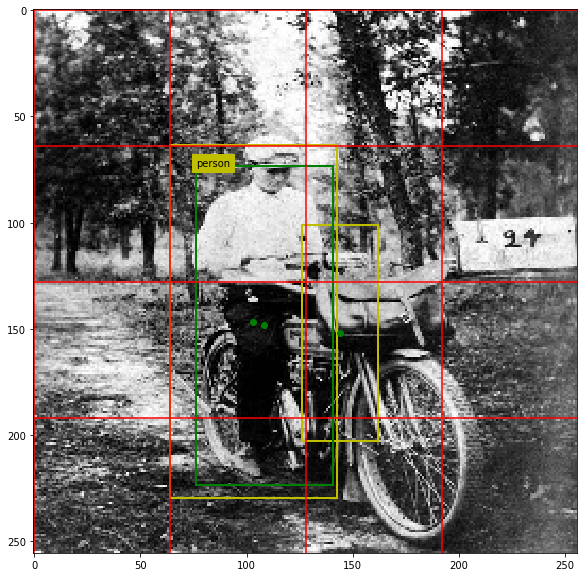

In [35]:
img_id = 5
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.31294528 0.6740745  0.48437965 0.14231852 0.14757544]
  [0.23149082 0.48897502 0.64603364 0.1382043  0.19209388]
  [0.19737542 0.58160025 0.71303475 0.13270241 0.21946889]
  [0.21591905 0.54035205 0.65603834 0.18450862 0.20414728]]

 [[0.41457424 0.57213885 0.68019795 0.40219182 0.68536925]
  [0.5579965  0.46827394 0.5660975  0.52404076 0.5761574 ]
  [0.60774463 0.29014495 0.5234324  0.4801225  0.5940327 ]
  [0.41509396 0.42954147 0.5249685  0.22030231 0.6405456 ]]

 [[0.30029374 0.547442   0.3794402  0.22874594 0.3093231 ]
  [0.395631   0.5421907  0.09525576 0.32781816 0.36924428]
  [0.38987797 0.5194924  0.08852091 0.25691688 0.29751742]
  [0.2397134  0.42180505 0.31827813 0.14715302 0.28771228]]

 [[0.10831663 0.31886494 0.30693072 0.1826646  0.38150543]
  [0.08358476 0.20168221 0.2788592  0.30944175 0.23042208]
  [0.10579023 0.40509653 0.47762644 0.12903276 0.1262191 ]
  [0.12740088 0.5731616  0.33851793 0.16675916 0.21348083]]]


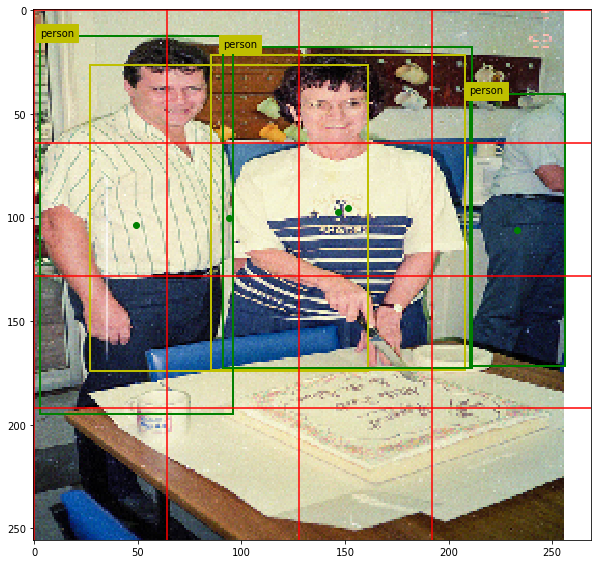

In [38]:
img_id = 8
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.10152489 0.5710749  0.74309164 0.09584677 0.17559898]
  [0.16036677 0.5788387  0.68609357 0.15388635 0.19742247]
  [0.18728068 0.46145976 0.7922691  0.1502833  0.22126493]
  [0.12388811 0.57166606 0.5558182  0.08797404 0.11637074]]

 [[0.22210506 0.57130134 0.58650714 0.04797179 0.17962357]
  [0.5689178  0.778762   0.7340331  0.39699847 0.75242925]
  [0.42638165 0.26779616 0.44226182 0.18870711 0.34862888]
  [0.16007984 0.36116946 0.73700786 0.12206572 0.31191918]]

 [[0.44169098 0.6633209  0.5805895  0.35642752 0.6959553 ]
  [0.49356353 0.44268912 0.27702945 0.413562   0.7305982 ]
  [0.62881136 0.59590816 0.38577577 0.29917425 0.49063978]
  [0.48142207 0.4707399  0.48285463 0.15729722 0.32461363]]

 [[0.19759175 0.6427898  0.43757865 0.1767303  0.2863627 ]
  [0.19677284 0.5043199  0.3187567  0.32010853 0.342641  ]
  [0.15612787 0.6012978  0.3108598  0.38476828 0.34300363]
  [0.17190555 0.56694305 0.37171546 0.19695956 0.23870346]]]


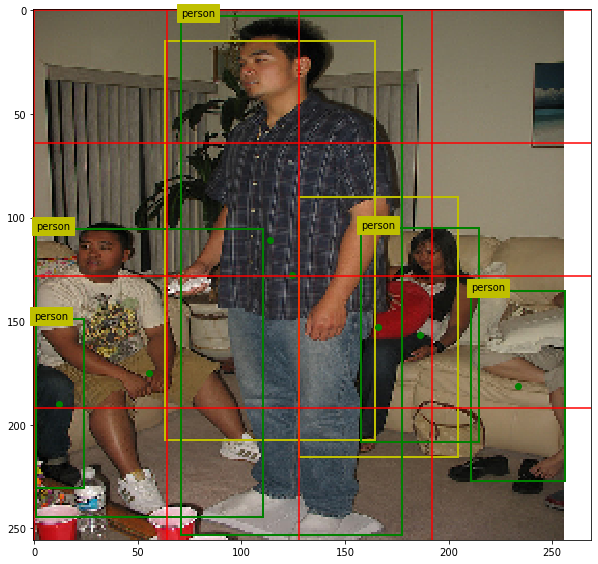

In [46]:
img_id = 16
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.16505864 0.48361447 0.6857071  0.09968436 0.15373755]
  [0.14065704 0.49620128 0.74472946 0.09533188 0.19071153]
  [0.12798351 0.577856   0.60517937 0.21988648 0.17932093]
  [0.16239607 0.3787212  0.661539   0.15035269 0.2364546 ]]

 [[0.33623642 0.7273735  0.5362247  0.17297891 0.2802014 ]
  [0.43288568 0.49209523 0.5010561  0.17561308 0.2972824 ]
  [0.32056713 0.33083326 0.50999296 0.19448045 0.2105771 ]
  [0.23913401 0.3234674  0.64179623 0.13839433 0.28049913]]

 [[0.42631018 0.755728   0.31697378 0.28147846 0.5505104 ]
  [0.526139   0.25827467 0.27374333 0.28508562 0.57106924]
  [0.3396359  0.55954355 0.35229754 0.32372653 0.47176734]
  [0.20831043 0.49543852 0.4038414  0.13172421 0.28631768]]

 [[0.13067871 0.642087   0.4388409  0.07825151 0.15886939]
  [0.08018672 0.35136664 0.4809059  0.08941624 0.15874755]
  [0.09904054 0.4281315  0.532241   0.10582855 0.12567514]
  [0.11125606 0.43364197 0.44618967 0.09195375 0.18153694]]]


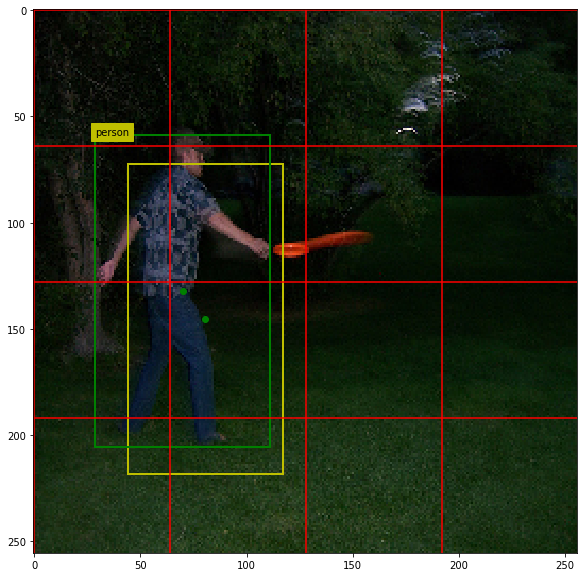

In [52]:
img_id = 22
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

[[[0.0742923  0.58010876 0.69176316 0.09020168 0.11264297]
  [0.13693923 0.5991417  0.6546623  0.14926392 0.18151313]
  [0.10695082 0.49115905 0.7610749  0.13945183 0.20308241]
  [0.09598497 0.5550721  0.6475871  0.10405856 0.18395951]]

 [[0.19757298 0.34979287 0.6797336  0.10017842 0.32485306]
  [0.39280245 0.61643755 0.76246333 0.15264621 0.3451255 ]
  [0.33215126 0.26992282 0.68749076 0.20804542 0.47720957]
  [0.16711324 0.44620693 0.7473949  0.08259243 0.166502  ]]

 [[0.23475704 0.5615647  0.505458   0.13448474 0.3198797 ]
  [0.37313014 0.5475753  0.5521549  0.13052404 0.38389271]
  [0.5557537  0.3367424  0.70262116 0.17585763 0.5937593 ]
  [0.25768873 0.3191061  0.6000188  0.13428459 0.43735036]]

 [[0.16914856 0.4514634  0.39265272 0.10499939 0.18682426]
  [0.19248566 0.49850893 0.37497914 0.13945925 0.33562183]
  [0.1680767  0.7672019  0.17508411 0.07629493 0.4123854 ]
  [0.16987291 0.48219442 0.30858725 0.08436158 0.13857293]]]


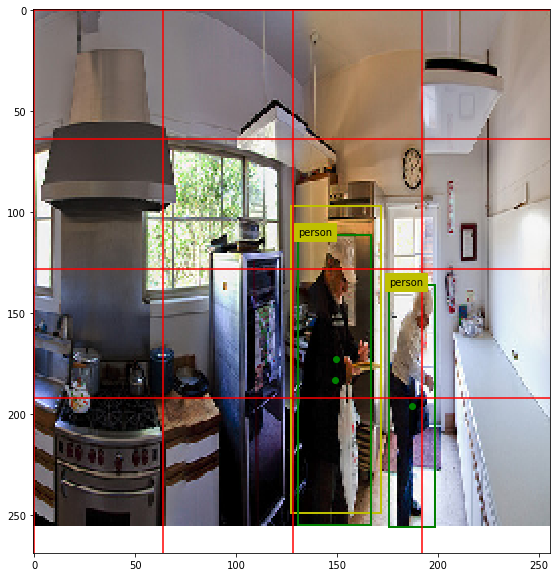

In [55]:
img_id = 25
print(p[img_id])
a = decode_yolo_to_anns(p[img_id], img_size, grid_size, confidence_threshold=0.5)
plot_img_with_bboxes(dev_x_new[img_id], anns=a, true_anns=dev_y_new[img_id], grid=(4, 4))

# Graphs of loss functions

<figure>
<center>
    <img src="loss_best_model.svg"/>
    <figcaption><small>Fig.1: Our best model. Spikes are where learning rate scheduler multiplied learning rate by 10.</small></figcaption>
</center>
</figure>

<figure>
<center>
    <img src="loss_larger_model.svg"/>
    <figcaption><small>Fig.2: In this model learning rate scheduler was not used, however there was no improvement on validation dataset.</small></figcaption>
</center>
</figure>